<a href="https://colab.research.google.com/github/yeabwang/Human-Emotions-Detection/blob/main/Human_Emotion_transfer_learning_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Multiply, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,DepthwiseConv2D,
                                     RandomContrast, Rescaling, Resizing, Reshape, ReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [ ]:
# Load the dataset

files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
!chmod 600 /root/.kaggle/kaggle.json

!pip install kaggle --upgrade
!pip install --upgrade pip

!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes
!unzip "human-emotions-datasethes.zip" -d "/content/dataset"

In [5]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-4,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 6799 files belonging to 3 classes.


In [7]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 2278 files belonging to 3 classes.


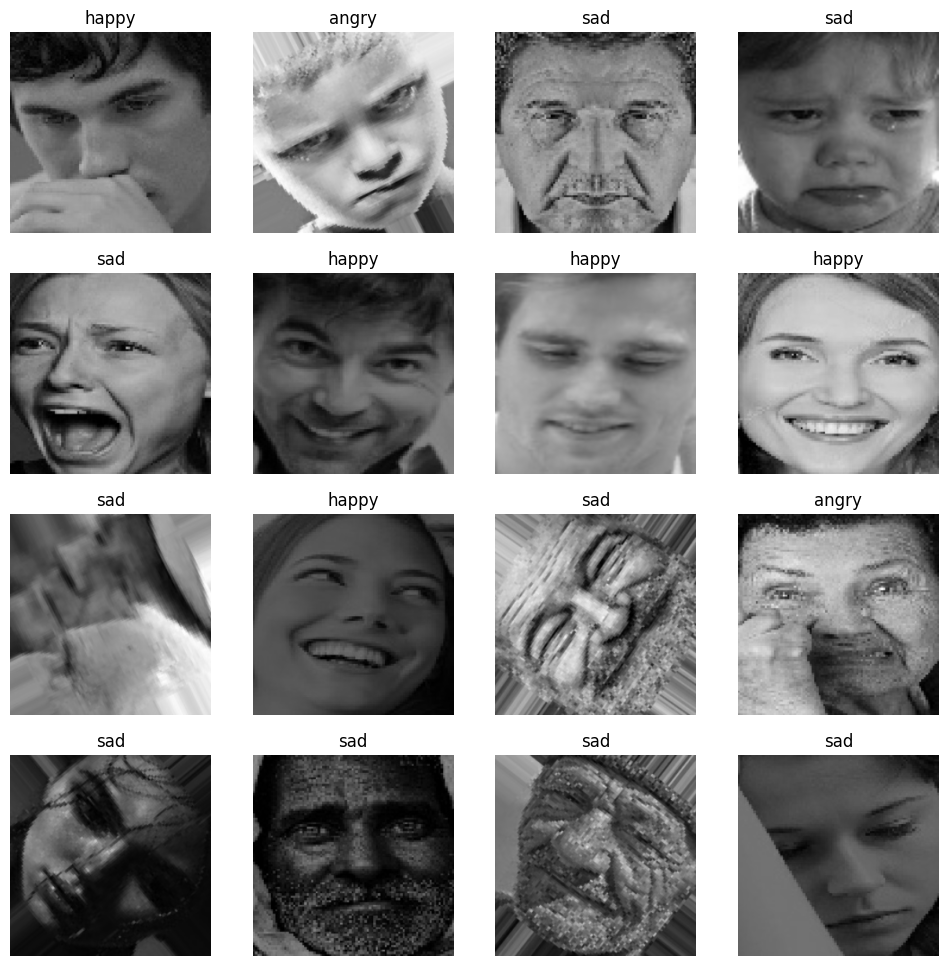

In [ ]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis =0).numpy()])
    plt.axis("off")

In [8]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomFlip(mode = "horizontal"),
    RandomContrast(factor = 0.1),
])

In [9]:
def augment_layer(image, label):
  return augment_layers(image, training=True), label

In [10]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [11]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [12]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

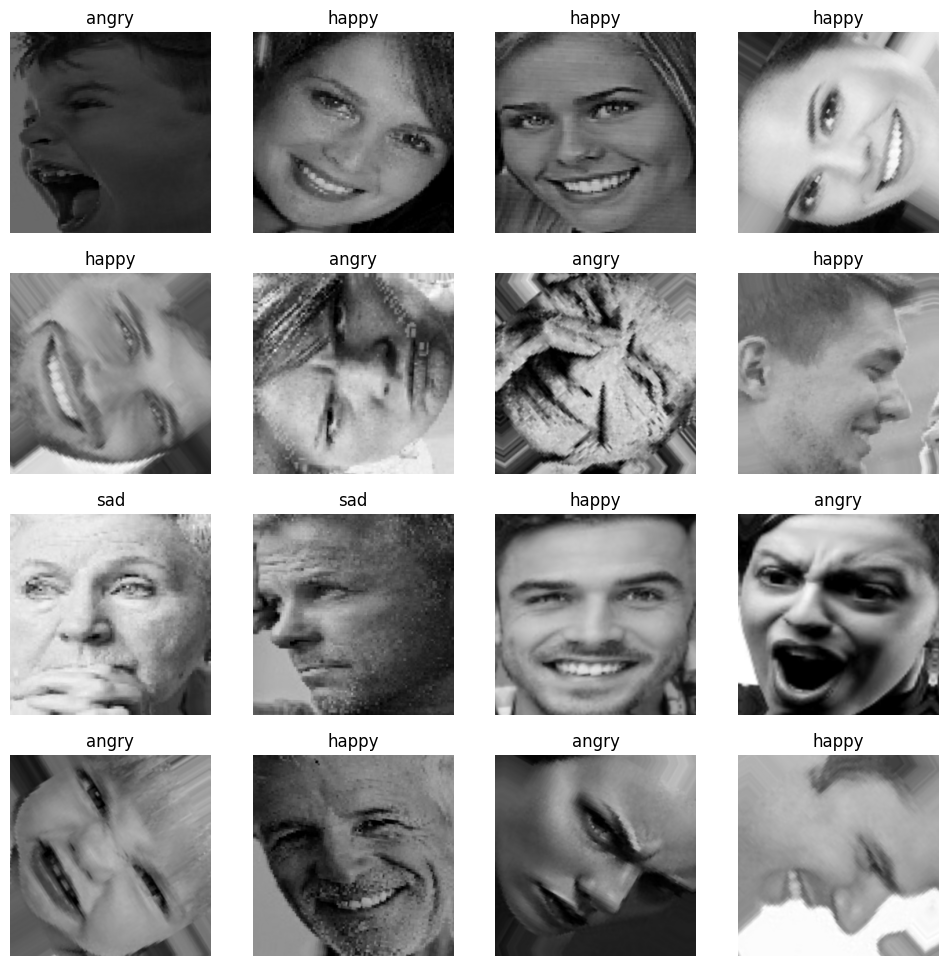

In [ ]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset_1.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis =0).numpy()])
    plt.axis("off")

In [13]:
# Load EfficientNetB4 without the top classification layer
backbone_model = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [14]:
# Freeze the base model layers initially
backbone_model.trainable = False

In [15]:
# Define the input
pretrained_input = Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3))

# Build the classification head
x = backbone_model(pretrained_input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(CONFIGURATION["N_DENSE_1"], activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(CONFIGURATION["N_DENSE_2"], activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
pretrained_output = Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")(x)

# Assemble the model
pretrained_model = Model(inputs=pretrained_input, outputs=pretrained_output, name="EfficientNetB4_pretrained")

# Display the model architecture
pretrained_model.summary()

Model: "EfficientNetB4_pretrained"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,646,050 (74.94 MB)

 Trainable params: 1,969,923 (7.51 MB)

 Non-trainable params: 17,676,127 (67.43 MB)

In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('pretrained.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [17]:
# Compile the model with a lower learning rate
pretrained_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]
)

In [ ]:
# Train only the top layers
history = pretrained_model.fit(
    mixed_dataset.map(cutmix),
    validation_data=validation_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    verbose=1,
    callbacks=callbacks
)

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4808 - loss: 1.3947 - top_k_accuracy: 0.7723
Epoch 1: val_accuracy improved from -inf to 0.67252, saving model to pretrained.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 597s 3s/step - accuracy: 0.4811 - loss: 1.3941 - top_k_accuracy: 0.7725 - val_accuracy: 0.6725 - val_loss: 0.7851 - val_top_k_accuracy: 0.8894 - learning_rate: 1.0000e-04
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5956 - loss: 1.0764 - top_k_accuracy: 0.8593
Epoch 2: val_accuracy improved from 0.67252 to 0.71817, saving model to pretrained.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 592s 3s/step - accuracy: 0.5957 - loss: 1.0764 - top_k_accuracy: 0.8593 - val_accuracy: 0.7182 - val_loss: 0.6494 - val_top_k_accuracy: 0.9126 - learning_rate: 1.0000e-04
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6043 - loss: 1.0347 - top_k_accuracy: 0.8685
Epoch 3: val_accuracy improved from 0.71817 to 0.72564, saving model to pretrained.keras
213/21

In [ ]:
len(backbone_model.layers)

475

In [ ]:
pretrained_model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.7633 - loss: 0.5722 - top_k_accuracy: 0.9246


[0.555188000202179, 0.762071967124939, 0.9284459948539734]

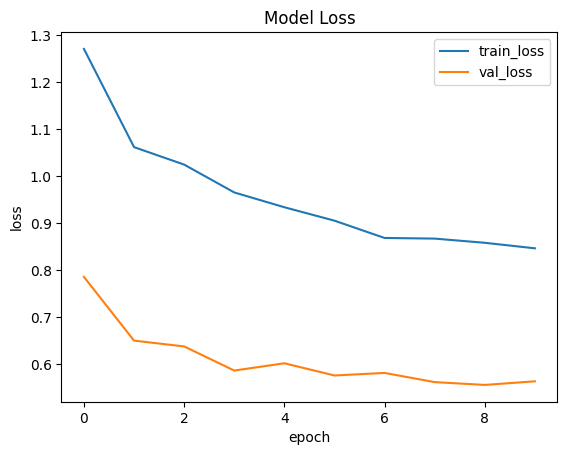

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

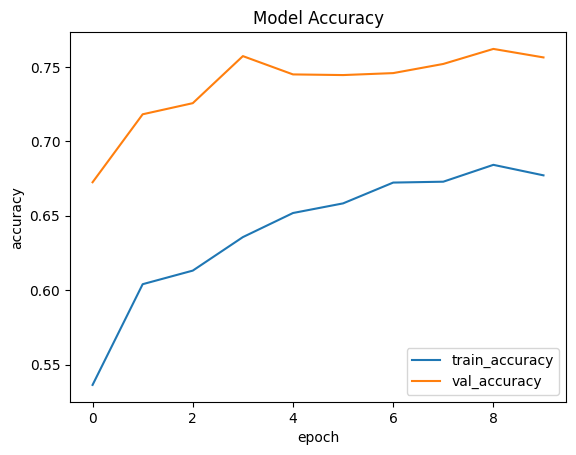

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
# Unfreeze the last 20 layers
for layer in backbone_model.layers[-20:]:
    backbone_model.trainable = True

In [ ]:
# Recompile with a smaller learning rate for fine-tuning
pretrained_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]
)

In [ ]:
# Continue training with fine-tuning
history_fine = pretrained_model.fit(
    mixed_dataset.map(cutmix),
    validation_data=validation_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    verbose=1,
    callbacks=callbacks
)

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4716 - loss: 1.2592 - top_k_accuracy: 0.7819
Epoch 1: val_accuracy improved from -inf to 0.60843, saving model to pretrained.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 1884s 9s/step - accuracy: 0.4716 - loss: 1.2590 - top_k_accuracy: 0.7819 - val_accuracy: 0.6084 - val_loss: 0.8763 - val_top_k_accuracy: 0.8648 - learning_rate: 1.0000e-05
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5365 - loss: 1.1155 - top_k_accuracy: 0.8184
Epoch 2: val_accuracy did not improve from 0.60843
213/213 ━━━━━━━━━━━━━━━━━━━━ 1802s 8s/step - accuracy: 0.5366 - loss: 1.1154 - top_k_accuracy: 0.8184 - val_accuracy: 0.6076 - val_loss: 0.8825 - val_top_k_accuracy: 0.8529 - learning_rate: 1.0000e-05
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5686 - loss: 1.0629 - top_k_accuracy: 0.8286
Epoch 3: val_accuracy improved from 0.60843 to 0.66506, saving model to pretrained.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 1782s 8s/step

In [ ]:
plt.plot(history_fine.history_fine['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history_fine.history_fine['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
test_img = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/112544.jpg_rotation_2.jpg")
im = tf.constant(test_img, dtype= tf.float32)
im= tf.expand_dims(im, axis=0)
prediction = CONFIGURATION["CLASS_NAMES"][tf.argmax(pretrained_model(im), axis = -1).numpy()[0]]
print(prediction)

In [ ]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    true_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis =0).numpy()]
    pred_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(pretrained_model(tf.expand_dims(images[i], axis=0)), axis = -1).numpy()[0]]
    plt.title("True value " + true_label + "\nModel Prediction " + pred_label)
    plt.axis("off")

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(pretrained_model(im))
  labels.append(label.numpy())

In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

Feature map

In [18]:
vgg_base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)
)

vgg_base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
def is_conv(layer_name):
  if "conv" in layer_name:
    return True
  else:
    return False

In [23]:
feature_maps = [layer.output for layer in vgg_base_model.layers[1:]]

feature_map_model = Model(
    inputs = vgg_base_model.input,
    outputs = feature_maps
)

feature_map_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/112544.jpg_rotation_2.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0)

f_maps = feature_map_model.predict(im)

print(len(f_maps))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
18


In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize = (256,256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.ones((f_size, f_size*n_channels))

  axs = plt.subplot(len(f_maps), 1, i+1)

  for j in range(n_channels):
    joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:0:512])
  plt.axis("off")

<ipython-input-26-b3e606e278b4>:12: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(joint_maps[:0:512])
